# Modèles A: GradientBosstingClassifier et XGBoost

In [2]:
import pandas as pd
from sklearn.pipeline import Pipeline
from preparation import FeatureEngineering, Preprocessing

pipeline = Pipeline([
    ('Feature_Engineering', FeatureEngineering()),
    ('preprocessing', Preprocessing()),
])
raw_data = pd.read_csv('data/data.csv', delimiter=';')

X, Y = pipeline.fit_transform(raw_data.drop(columns='y'), raw_data['y'])

X.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,campaign_efficiency,...,poutcome_success,prev_contact_15lt,prev_contact_Never,prev_contact_0-7,prev_contact_7-15,age_cat_60lt,age_cat_0-23,age_cat_23-30,age_cat_30-40,age_cat_40-60
0,1.533034,-0.565922,-0.170834,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,-0.146647,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.628993,-0.565922,-0.170834,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,-0.146647,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.290186,-0.565922,-0.170834,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,-0.146647,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.002309,-0.565922,-0.170834,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,-0.146647,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.533034,-0.565922,-0.170834,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,-0.146647,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [3]:
positive = round(Y.sum()/len(Y) * 100)
negative = 100 - positive
print(f'True: {positive}%, Negative:{negative}%')

True: 11%, Negative:89%


Split datasets en test et train (train pour la cross validation et le tuning des tresholds) stratifiés sur variables target

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import metrics
from utils import cv_zoom

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_train_cv, X_train_threshold, y_train_cv, y_train_threshold = train_test_split(X_train, y_train, test_size=0.2, random_state=2024, stratify=y_train)

num_folds = 5
cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Gradient Boosting

## Gradient Boosting Classifier: maximisation precision score

In [4]:
from sklearn.ensemble import GradientBoostingClassifier

# Hyperparamètres et nombre de folds pour la validation croisée
param_grid = {
    "max_depth": [4, 6, 8, 10],  # Largeur des arbres
    "n_estimators": [25, 50, 75, 100],  # Nombre d'arbres
    "subsample": [0.3, 0.5, 0.7],  # Ratio de sous-échantillonnage
    "learning_rate": [0.05, 0.1, 1]
}

gb = GradientBoostingClassifier(random_state=42)

scoring = 'precision'
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
)
grid_search.fit(X_train_cv, y_train_cv)

# Les meilleurs hyperparamètres
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres : ", best_params)

best_gb_precision = GradientBoostingClassifier(random_state=42, **best_params)
cv_zoom(model=best_gb_precision, X_train=X_train_cv, y_train=y_train_cv, num_folds=num_folds)

Meilleurs hyperparamètres :  {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 25, 'subsample': 0.7}
Fold  : precision  | accuracy   | recall    
Fold 1:      0.826 |      0.901 |      0.152
Fold 2:      0.779 |      0.899 |      0.148
Fold 3:      0.796 |      0.898 |      0.131
Fold 4:      0.748 |        0.9 |      0.165
Fold 5:      0.746 |      0.898 |      0.143


Testing check

In [8]:
best_gb_precision.fit(X_train, y_train)
y_pred = best_gb_precision.predict(X_test)

precision = metrics.precision_score(y_test, y_pred)
print(f"Précision : {precision}")
f1 = metrics.f1_score(y_test, y_pred)
print(f"F score : {f1}")

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
results = {
    'True': [tp, fn],
    'False': [fp, tn]
}
results = pd.DataFrame(results, index=['Predicted True', 'Predicted False'])
results

Précision : 0.7894736842105263
F score : 0.2456778889899909


,True,False
Predicted True,135,36
Predicted False,793,7274


## Gradient Boosting Classifier: maximisation f1 score

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

# Hyperparamètres et nombre de folds pour la validation croisée
param_grid = {
    "max_depth": [4, 6, 8, 10],  # Largeur des arbres
    "n_estimators": [25, 50, 75, 100],  # Nombre d'arbres
    "subsample": [0.3, 0.5, 0.7],  # Ratio de sous-échantillonnage
    "learning_rate": [0.05, 0.1, 1]
}

gb = GradientBoostingClassifier(random_state=42)

scoring = 'f1'
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
)
grid_search.fit(X_train_cv, y_train_cv)

# Les meilleurs hyperparamètres
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres : ", best_params)
best_gb = GradientBoostingClassifier(random_state=42, **best_params)

cv_zoom(model=best_gb, X_train=X_train_cv, y_train=y_train_cv, num_folds=num_folds)

Meilleurs hyperparamètres :  {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 75, 'subsample': 0.7}
Fold  : precision  | accuracy   | recall    
Fold 1:      0.557 |      0.894 |      0.271
Fold 2:      0.597 |      0.898 |      0.291
Fold 3:      0.552 |      0.893 |      0.276
Fold 4:       0.55 |      0.894 |      0.303
Fold 5:      0.599 |      0.898 |      0.286


Testing check

In [10]:
best_gb.fit(X_train, y_train)
y_pred = best_gb.predict(X_test)

precision = metrics.precision_score(y_test, y_pred)
print(f"Précision : {precision}")
f1 = metrics.f1_score(y_test, y_pred)
print(f"F score : {f1}")

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
results = {
    'True': [tp, fn],
    'False': [fp, tn]
}
results = pd.DataFrame(results, index=['Predicted True', 'Predicted False'])
results

Précision : 0.6171171171171171
F score : 0.3994169096209913


,True,False
Predicted True,274,170
Predicted False,654,7140


# XGBoost

## Extreme Gradient Boosting Classifier: maximisation precision score without classs weights

In [11]:
import xgboost as xgb

param_grid = {
    "max_depth": [4, 6, 8, 10],  # Largeur des arbres
    "n_estimators": [25, 50, 75, 100],  # Nombre d'arbres
    "subsample": [0.3, 0.5, 0.7],  # Ratio de sous-échantillonnage
    "learning_rate": [0.05, 0.1, 1]
}

# from sklearn.metrics import f1_score
xgb_model = xgb.XGBClassifier(
    tree_method='exact',
    # eval_metric=f1_score
    #scale_pos_weight=np.sqrt(negative/positive) # donne plus de poids aux positives
)

scoring = 'precision'
clf = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
)

clf.fit(X_train_cv, y_train_cv)
print(clf.best_score_)
print(clf.best_params_)

cv_zoom(model=clf.best_estimator_, X_train=X_train_cv, y_train=y_train_cv, num_folds=num_folds)
best_xgb_precision = clf.best_estimator_
best_xgb_precision.fit(X_train, y_train)

/home/theo/Documents/Cours/Dauphine/ml-python/.env/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


0.776799816345271
{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 25, 'subsample': 0.3}
Fold  : precision  | accuracy   | recall    
Fold 1:      0.856 |      0.901 |       0.15
Fold 2:      0.743 |      0.897 |      0.126
Fold 3:      0.766 |      0.897 |      0.121
Fold 4:      0.715 |      0.897 |      0.148
Fold 5:      0.755 |      0.898 |      0.135


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Testing check

In [12]:
y_pred = best_xgb_precision.predict(X_test)

precision = metrics.precision_score(y_test, y_pred)
print(f"Précision : {precision}")
f1 = metrics.f1_score(y_test, y_pred)
print(f"F score : {f1}")

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
results = {
    'True': [tp, fn],
    'False': [fp, tn]
}
results = pd.DataFrame(results, index=['Predicted True', 'Predicted False'])
results

Précision : 0.7834394904458599
F score : 0.22672811059907835


,True,False
Predicted True,123,34
Predicted False,805,7276


## Extreme Gradient Boosting Classifier: maximisation precision score with classs weights

In [13]:
import xgboost as xgb

param_grid = {
    "max_depth": [4, 6, 8, 10],  # Largeur des arbres
    "n_estimators": [25, 50, 75, 100],  # Nombre d'arbres
    "subsample": [0.3, 0.5, 0.7],  # Ratio de sous-échantillonnage
    "learning_rate": [0.05, 0.1, 1]
}

# from sklearn.metrics import f1_score
xgb_model = xgb.XGBClassifier(
    tree_method='exact',
    # eval_metric=f1_score
    scale_pos_weight=negative/positive # donne plus de poids aux positives
)

scoring = 'precision'
clf = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
)

clf.fit(X_train_cv, y_train_cv)
print(clf.best_score_)
print(clf.best_params_)

cv_zoom(model=clf.best_estimator_, X_train=X_train_cv, y_train=y_train_cv, num_folds=num_folds)
best_xgb_precision_weights = clf.best_estimator_
best_xgb_precision_weights.fit(X_train, y_train)

0.4193656252364241
{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 25, 'subsample': 0.3}
Fold  : precision  | accuracy   | recall    
Fold 1:      0.426 |      0.865 |      0.581
Fold 2:      0.427 |      0.865 |      0.584
Fold 3:      0.417 |      0.862 |      0.571
Fold 4:      0.416 |      0.862 |      0.564
Fold 5:      0.425 |      0.864 |      0.574


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Testing check

In [14]:
y_pred = best_xgb_precision_weights.predict(X_test)

precision = metrics.precision_score(y_test, y_pred)
print(f"Précision : {precision}")
f1 = metrics.f1_score(y_test, y_pred)
print(f"F score : {f1}")

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
results = {
    'True': [tp, fn],
    'False': [fp, tn]
}
results = pd.DataFrame(results, index=['Predicted True', 'Predicted False'])
results

Précision : 0.43435858964741186
F score : 0.5121627598407784


,True,False
Predicted True,579,754
Predicted False,349,6556


## Extreme Gradient Boosting Classifier: maximisation f1 score without classs weights

In [15]:
import xgboost as xgb

param_grid = {
    "max_depth": [4, 6, 8, 10],  # Largeur des arbres
    "n_estimators": [25, 50, 75, 100],  # Nombre d'arbres
    "subsample": [0.3, 0.5, 0.7],  # Ratio de sous-échantillonnage
    "learning_rate": [0.05, 0.1, 1]
}

# from sklearn.metrics import f1_score
xgb_model = xgb.XGBClassifier(
    tree_method='exact',
    # eval_metric=f1_score
    #scale_pos_weight=np.sqrt(negative/positive) # donne plus de poids aux positives
)

scoring = 'f1'
clf = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
)

clf.fit(X_train_cv, y_train_cv)
print(clf.best_score_)
print(clf.best_params_)

cv_zoom(model=clf.best_estimator_, X_train=X_train_cv, y_train=y_train_cv, num_folds=num_folds)
best_xgb_f1 = clf.best_estimator_
best_xgb_f1.fit(X_train, y_train)

0.38972864928843504
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 75, 'subsample': 0.5}
Fold  : precision  | accuracy   | recall    
Fold 1:      0.608 |      0.898 |      0.269
Fold 2:      0.614 |      0.899 |       0.29
Fold 3:      0.582 |      0.896 |      0.268
Fold 4:      0.542 |      0.892 |      0.285
Fold 5:      0.587 |      0.896 |      0.266


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Testing check

In [16]:
y_pred = best_xgb_f1.predict(X_test)

precision = metrics.precision_score(y_test, y_pred)
print(f"Précision : {precision}")
f1 = metrics.f1_score(y_test, y_pred)
print(f"F score : {f1}")

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
results = {
    'True': [tp, fn],
    'False': [fp, tn]
}
results = pd.DataFrame(results, index=['Predicted True', 'Predicted False'])
results

Précision : 0.6269662921348315
F score : 0.4064093226511289


,True,False
Predicted True,279,166
Predicted False,649,7144


## Extreme Gradient Boosting Classifier: maximisation f1 score with classs weights

In [17]:
import xgboost as xgb

param_grid = {
    "max_depth": [4, 6, 8, 10],  # Largeur des arbres
    "n_estimators": [25, 50, 75, 100],  # Nombre d'arbres
    "subsample": [0.3, 0.5, 0.7],  # Ratio de sous-échantillonnage
    "learning_rate": [0.05, 0.1, 1]
}

# from sklearn.metrics import f1_score
xgb_model = xgb.XGBClassifier(
    tree_method='exact',
    # eval_metric=f1_score
    scale_pos_weight=negative/positive # donne plus de poids aux positives
)

scoring = 'f1'
clf = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
)

clf.fit(X_train_cv, y_train_cv)
print(clf.best_score_)
print(clf.best_params_)

cv_zoom(model=clf.best_estimator_, X_train=X_train_cv, y_train=y_train_cv, num_folds=num_folds)
best_xgb_f1_weights = clf.best_estimator_
best_xgb_f1_weights.fit(X_train, y_train)

0.4872077902884894
{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 25, 'subsample': 0.5}
Fold  : precision  | accuracy   | recall    
Fold 1:      0.422 |      0.862 |      0.593
Fold 2:      0.419 |      0.862 |      0.591
Fold 3:      0.418 |      0.862 |      0.586
Fold 4:      0.408 |      0.859 |      0.561
Fold 5:       0.43 |      0.866 |      0.588


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Testing check

In [18]:
y_pred = best_xgb_f1.predict(X_test)

precision = metrics.precision_score(y_test, y_pred)
print(f"Précision : {precision}")
f1 = metrics.f1_score(y_test, y_pred)
print(f"F score : {f1}")

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
results = {
    'True': [tp, fn],
    'False': [fp, tn]
}
results = pd.DataFrame(results, index=['Predicted True', 'Predicted False'])
results

Précision : 0.6269662921348315
F score : 0.4064093226511289


,True,False
Predicted True,279,166
Predicted False,649,7144


# Tuning des tresholds

In [5]:
# Pour éviter de faire le grid_search à chaque fois:

from sklearn.ensemble import GradientBoostingClassifier

best_params = {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 25, 'subsample': 0.7} 
best_gb_precision = GradientBoostingClassifier(random_state=42, **best_params)
best_gb_precision.fit(X_train_cv, y_train_cv)

best_params = {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 75, 'subsample': 0.7} 
best_gb_f1 = GradientBoostingClassifier(random_state=42, **best_params)
best_gb_f1.fit(X_train_cv, y_train_cv)

import xgboost as xgb

best_params = {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 25, 'subsample': 0.3}
best_xgb_precision = xgb.XGBClassifier(random_state=42, tree_method='exact', **best_params)
best_xgb_precision.fit(X_train_cv, y_train_cv)

best_params = {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 25, 'subsample': 0.3}
best_xgb_precision_weights = xgb.XGBClassifier(random_state=42, tree_method='exact', scale_pos_weight=negative/positive , **best_params)
best_xgb_precision_weights.fit(X_train_cv, y_train_cv)

best_params = {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 75, 'subsample': 0.5}
best_xgb_f1 = xgb.XGBClassifier(random_state=42, tree_method='exact', **best_params)
best_xgb_f1.fit(X_train_cv, y_train_cv)

best_params = {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 25, 'subsample': 0.5}
best_xgb_f1_weights = xgb.XGBClassifier(random_state=42, tree_method='exact', scale_pos_weight=negative/positive , **best_params)
best_xgb_f1_weights.fit(X_train_cv, y_train_cv)

classifiers = {
    "GBoost precision": best_gb_precision,
    "GBoost f1": best_gb_f1,
    "XGBoost precision no weights": best_xgb_precision, 
    "XGBoost precision weights": best_xgb_precision_weights, 
    "XGBoost f1 no weights": best_xgb_f1, 
    "XGBoost f1 weights": best_xgb_f1_weights, 
}

/home/theo/Documents/Cours/Dauphine/ml-python/.env/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


## ROC and AUC curves avec treshold original

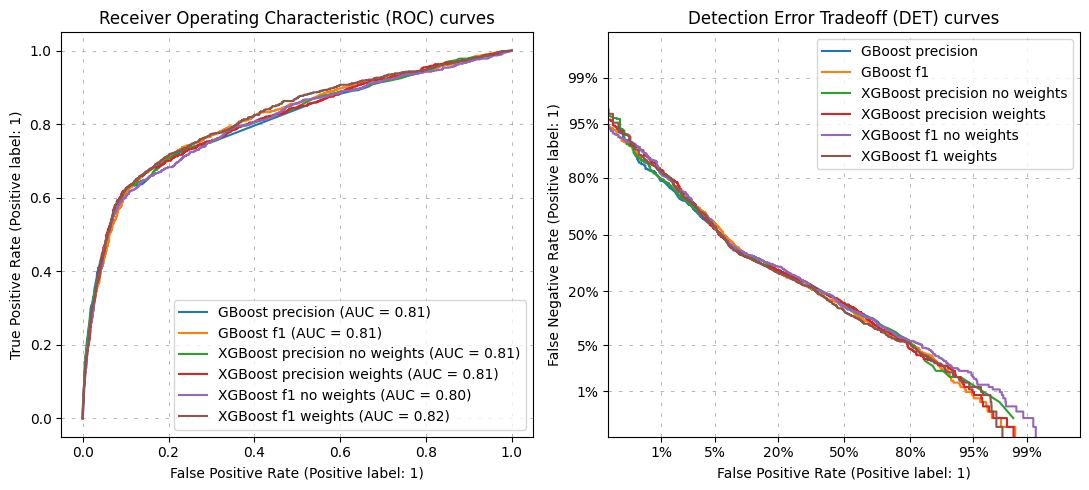

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(visible=True, which="major", linestyle="--", dashes=(5, 10), color='gray', linewidth=0.5, alpha=0.8)
ax_det.grid(visible=True, which="major", linestyle="--", dashes=(5, 10), color='gray', linewidth=0.5, alpha=0.8)

# ax_roc.legend(fontsize='small')
# ax_det.legend(fontsize='small')

plt.legend()
plt.tight_layout()
plt.show()

Courbe pas très pertinente car l'accuray est environ la même pour tous les modèles, car beaucoup de TN

## Tuning des tresholds et Business Metric

In [16]:
def business_metric(y_true, y_pred, benefit=1, cost=1, missed_opportunity=0.5):
    """
    Métrique personnalisée basée sur les bénéfices et coûts.

    Args:
     - y_true : np.array
        Les vraies étiquettes (0 ou 1).
     - y_pred_proba : np.array
        Les probabilités prédites par le modèle pour la classe positive.
     - benefit : float
        Le gain pour une prédiction correcte d'un vrai positif (TP).
     - cost : float
        Le coût d'un faux positif (FP).
     - missed_opportunity : float
        Le coût d'une opportunité manquée pour un faux négatif (FN).

    Returns:
    float
        La valeur nette ajustée.
    """
    
    # Calculer les métriques de confusion
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tn = np.sum((y_true == 0) & (y_pred == 0))

    # Calculer la valeur nette ajustée
    net_value = (tp * benefit) - (fp * cost) - (fn * missed_opportunity)
    return net_value

cost = 1.5
missed_opportunity = 0.5
def calculate_business_metric(model, X_test, y_test, thresholds, benefit=1, cost=cost, missed_opportunity=missed_opportunity):
   scores = []
   for threshold in thresholds:
      y_pred = (model.predict_proba(X_test)[:, 1] >= threshold).astype(int)
      score = business_metric(y_test, y_pred, benefit=benefit, cost=cost, missed_opportunity=missed_opportunity)
      scores.append(score)
   return scores


On plot 
1. Precision-recall curve, 
2. ROC curve 
3. Business metric vs decision treshold curve

On choisit le treshold optimal comme étant celui qui maximise la métrique de business

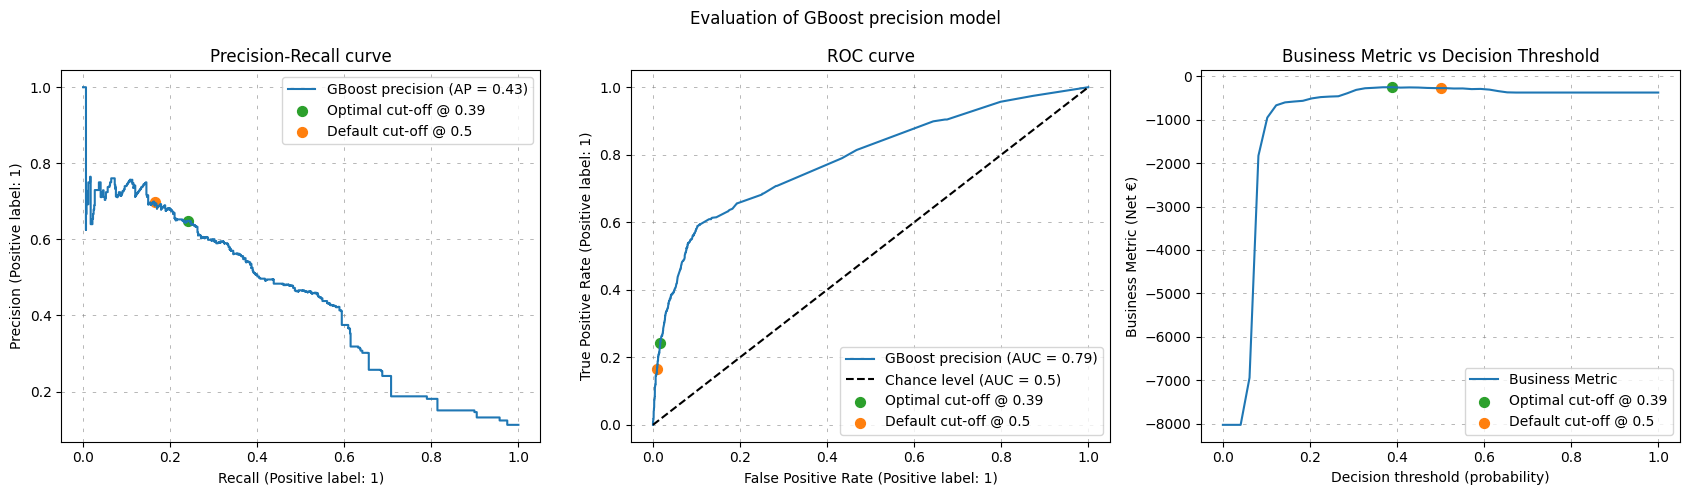

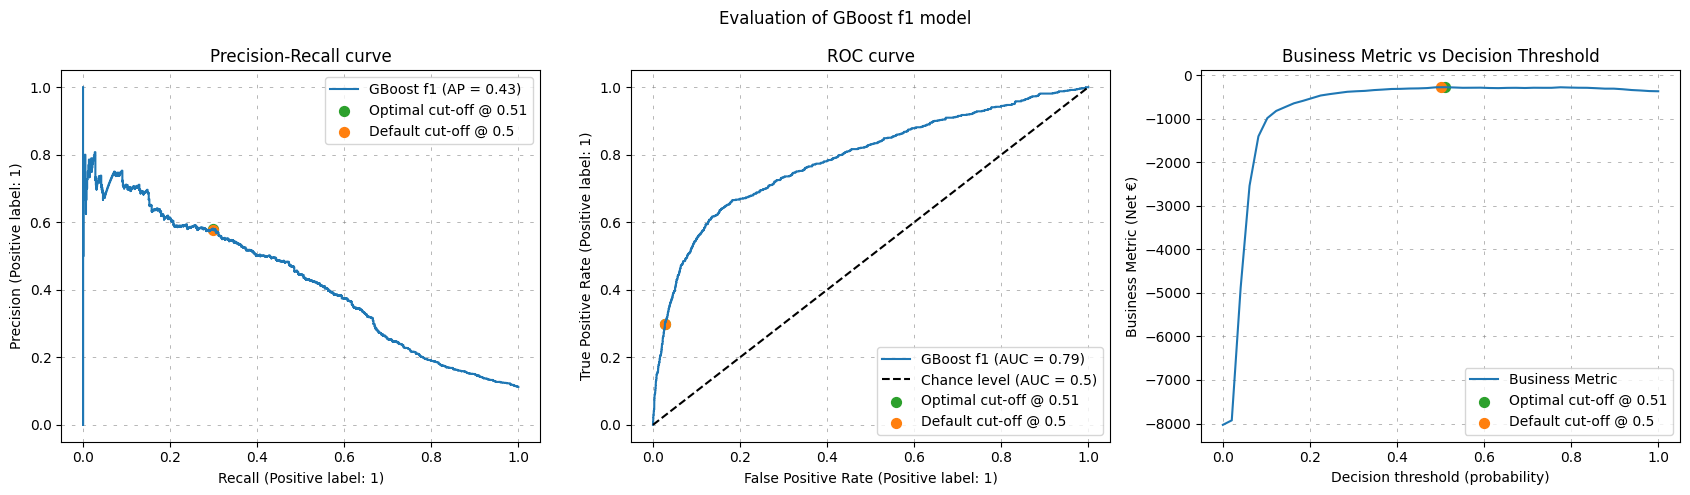

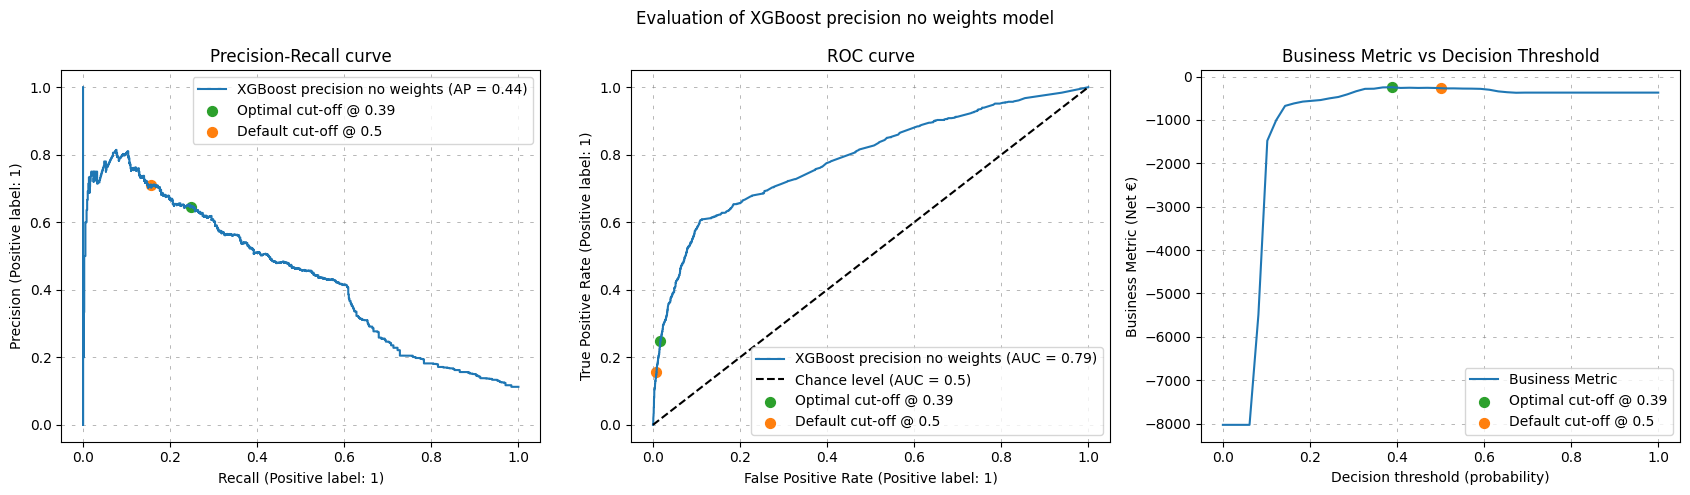

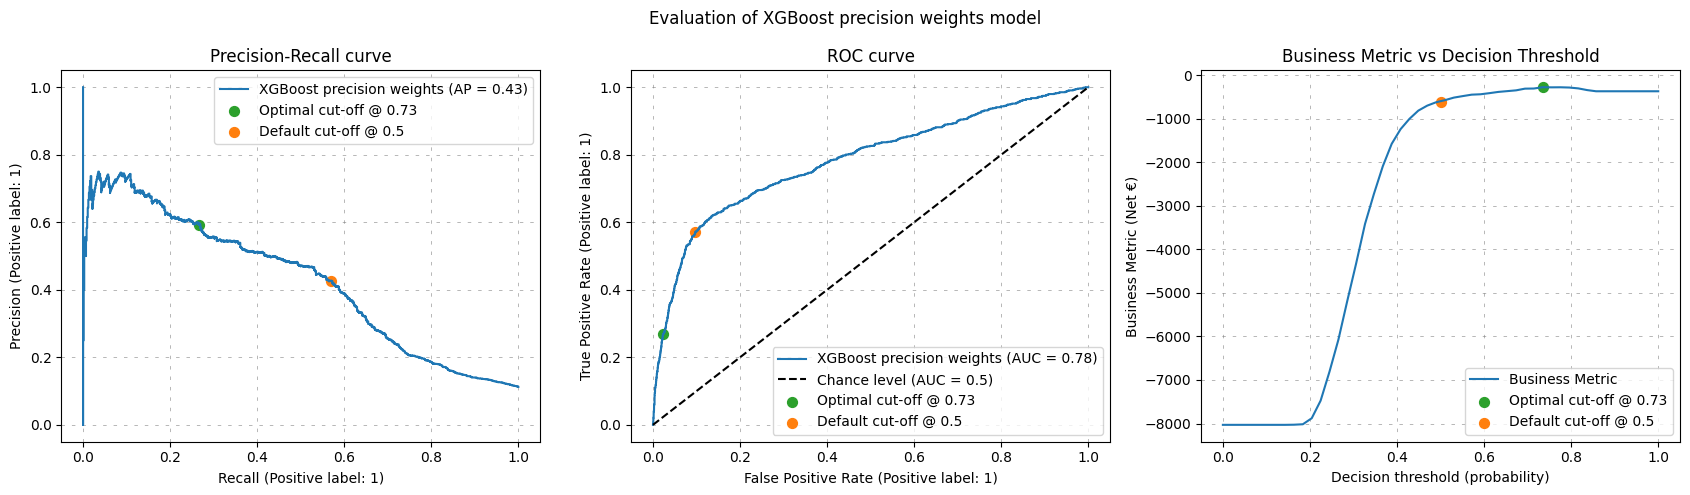

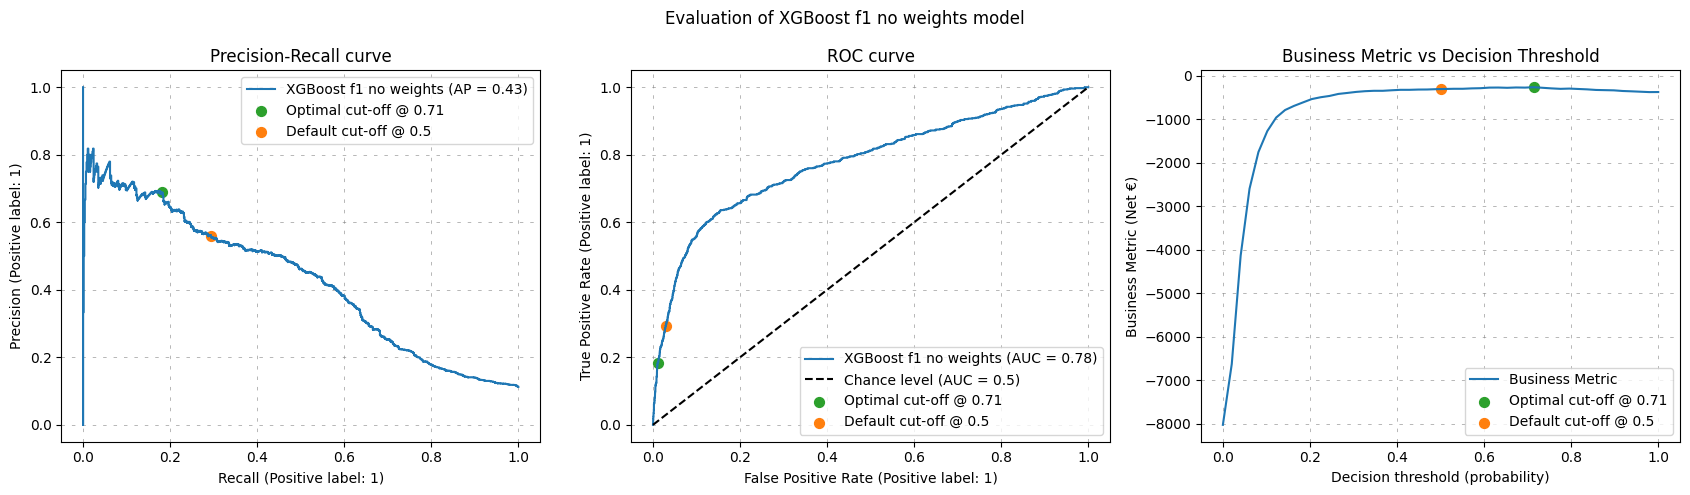

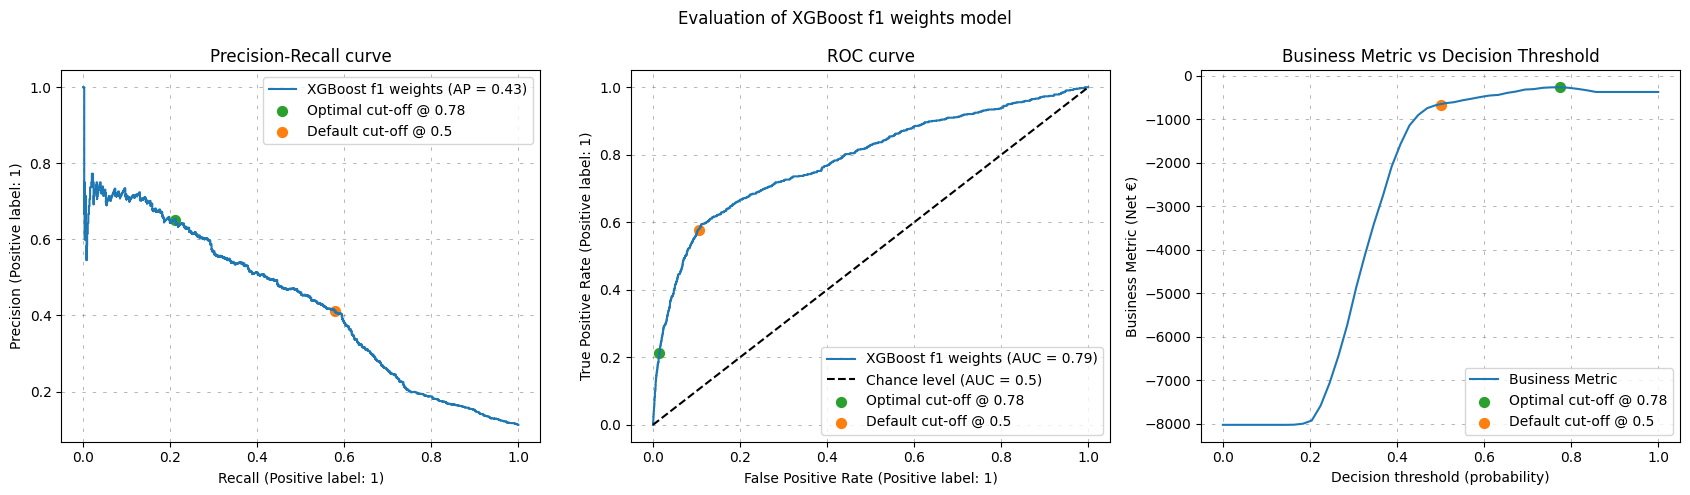

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

optimal_thresholds = {}
metric_method = 'business metric' # or 'metric from model name'

for name, model in classifiers.items():
    y_pred_proba = model.predict_proba(X_train_threshold)[:, 1]
    thresholds = np.linspace(0.0, 1.0, 50)

    if "f1" in name:
        metric_optimized = "f1"
    elif "precision" in name:
        metric_optimized = 'precision'
    
    # Calcul de la business metric et de l'optimal threshold
    business_scores = calculate_business_metric(model, X_train_threshold, y_train_threshold, thresholds)
    
    # Seuil par défaut
    default_threshold = 0.5
    default_precision = metrics.precision_score(y_train_threshold, (y_pred_proba >= default_threshold).astype(int))
    default_recall = metrics.recall_score(y_train_threshold, (y_pred_proba >= default_threshold).astype(int))

    # Sélectionne le threshold optimal qui maximise la métrique en question
    if metric_method == 'metric from model name':
        if metric_optimized == 'f1':
            optimal_idx = np.argmax([metrics.f1_score(y_train_threshold, (y_pred_proba >= t).astype(int), zero_division=0) for t in thresholds])
        elif metric_optimized == 'precision':
            optimal_idx = np.argmax([metrics.precision_score(y_train_threshold, (y_pred_proba >= t).astype(int), zero_division=0) for t in thresholds])
        else:
            raise ValueError(f"Unsupported metric optimized: {metric_optimized}")
    elif metric_method == 'business metric':
        optimal_idx = np.argmax(business_scores)
    else:
        raise ValueError(f"Unsupported metric method: {metric_method}")
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds[name] = optimal_threshold


    # Création des graphiques
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))

    # Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(
        model, X_train_threshold, y_train_threshold, ax=axs[0], name=name
    )
    # Point optimal
    axs[0].scatter(
        recall := metrics.recall_score(y_train_threshold, (y_pred_proba >= optimal_threshold).astype(int)),
        precision := metrics.precision_score(y_train_threshold, (y_pred_proba >= optimal_threshold).astype(int)),
        color="tab:green",
        s=50,
        label=f"Optimal cut-off @ {optimal_threshold:.2f}",
    )
    # Point par défaut
    axs[0].scatter(
        default_recall,
        default_precision,
        color="tab:orange",
        s=50,
        label="Default cut-off @ 0.5",
    )
    axs[0].set_title("Precision-Recall curve")
    axs[0].legend()

    # ROC curve
    RocCurveDisplay.from_estimator(
        model,
        X_train_threshold,
        y_train_threshold,
        ax=axs[1],
        name=name,
        plot_chance_level=True,
    )
    fpr, tpr, roc_thresholds = metrics.roc_curve(y_train_threshold, y_pred_proba)
    optimal_fpr = fpr[np.abs(roc_thresholds - optimal_threshold).argmin()]
    optimal_tpr = tpr[np.abs(roc_thresholds - optimal_threshold).argmin()]
    default_fpr = fpr[np.abs(roc_thresholds - default_threshold).argmin()]
    default_tpr = tpr[np.abs(roc_thresholds - default_threshold).argmin()]
    # Point optimal
    axs[1].scatter(
        optimal_fpr,
        optimal_tpr,
        color="tab:green",
        s=50,
        label=f"Optimal cut-off @ {optimal_threshold:.2f}",
    )
    # Point par défaut
    axs[1].scatter(
        default_fpr,
        default_tpr,
        color="tab:orange",
        s=50,
        label="Default cut-off @ 0.5",
    )
    axs[1].set_title("ROC curve")
    axs[1].legend()

    # Business metric curve
    axs[2].plot(
        thresholds,
        business_scores,
        color="tab:blue",
        label="Business Metric",
    )
    axs[2].scatter(
        optimal_threshold,
        business_scores[optimal_idx],
        color="tab:green",
        s=50,
        label=f"Optimal cut-off @ {optimal_threshold:.2f}",
    )
    default_idx = np.abs(thresholds - default_threshold).argmin()
    axs[2].scatter(
        default_threshold,
        business_scores[default_idx],
        color="tab:orange",
        s=50,
        label="Default cut-off @ 0.5",
    )
    axs[2].legend()
    axs[2].set_xlabel("Decision threshold (probability)")
    axs[2].set_ylabel("Business Metric (Net €)")
    axs[2].set_title("Business Metric vs Decision Threshold")

    # Ajouter des grilles aux graphiques
    for ax in axs:
        ax.grid(visible=True, which="major", linestyle="--", dashes=(5, 10), color='gray', linewidth=0.5, alpha=0.8)

    # Finaliser le layout
    _ = fig.suptitle(f"Evaluation of {name} model")
    plt.tight_layout()
    plt.savefig(f'modelsA-plots/{name}.pdf')
    plt.show()

## Analyse des résultats

### Performance avec le threshold optimal

In [31]:
results = []

# Calculer les métriques pour chaque modèle
for name, model in classifiers.items():

    y_proba = model.predict_proba(X_test)[:, 1]
    optimal_threshold = optimal_thresholds[name] 
    y_pred = (y_proba >= optimal_threshold).astype(int)

    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    business = business_metric(y_test, y_pred, benefit=1, cost=cost, missed_opportunity=missed_opportunity)

    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    confusion_matrix = {
        'True': [tp, fn],
        'False': [fp, tn]
    }
    confusion_matrix = pd.DataFrame(confusion_matrix, index=['Predicted True', 'Predicted False'])

    results.append({
        'Model': name,
        'Optimal Threshold': round(optimal_threshold, 2),
        'Precision': round(precision,2),
        'Recall': round(recall,2),
        'F1': round(f1,2),
        'Business Metric': round(business),
        'Confusion Matrix': confusion_matrix
    })

metrics_df = pd.DataFrame(results).drop(columns='Confusion Matrix').set_index('Model')
metrics_df

,Optimal Threshold,Precision,Recall,F1,Business Metric
Model,,,,,
GBoost precision,0.39,0.70,0.22,0.33,-292
GBoost f1,0.51,0.62,0.29,0.40,-311
XGBoost precision no weights,0.39,0.71,0.22,0.34,-284
XGBoost precision weights,0.73,0.62,0.27,0.38,-314
XGBoost f1 no weights,0.71,0.73,0.16,0.26,-326
XGBoost f1 weights,0.78,0.68,0.20,0.31,-318


In [32]:
results[5]['Confusion Matrix']

,True,False
Predicted True,186,89
Predicted False,742,7221


### Performance avec le threshold par défault

In [33]:
results = []

# Calculer les métriques pour chaque modèle
for name, model in classifiers.items():

    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    business = business_metric(y_test, y_pred, benefit=1, cost=cost, missed_opportunity=missed_opportunity)

    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    confusion_matrix = {
        'True': [tp, fn],
        'False': [fp, tn]
    }
    confusion_matrix = pd.DataFrame(confusion_matrix, index=['Predicted True', 'Predicted False'])

    results.append({
        'Model': name,
        'Default Threshold': 0.5,
        'Precision': round(precision,2),
        'Recall': round(recall,2),
        'F1': round(f1,2),
        'Business Metric': round(business),
        'Confusion Matrix': confusion_matrix
    })

metrics_df = pd.DataFrame(results).drop(columns='Confusion Matrix').set_index('Model')
metrics_df

,Default Threshold,Precision,Recall,F1,Business Metric
Model,,,,,
GBoost precision,0.5,0.79,0.15,0.25,-316
GBoost f1,0.5,0.61,0.30,0.40,-311
XGBoost precision no weights,0.5,0.77,0.13,0.22,-336
XGBoost precision weights,0.5,0.45,0.59,0.51,-638
XGBoost f1 no weights,0.5,0.61,0.30,0.41,-308
XGBoost f1 weights,0.5,0.44,0.61,0.51,-692


Quelques confusion matrix 

In [20]:
results[0]['Confusion Matrix']

,True,False
Predicted True,136,37
Predicted False,792,7273


In [21]:
results[1]['Confusion Matrix']

,True,False
Predicted True,277,175
Predicted False,651,7135


### Features importance

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


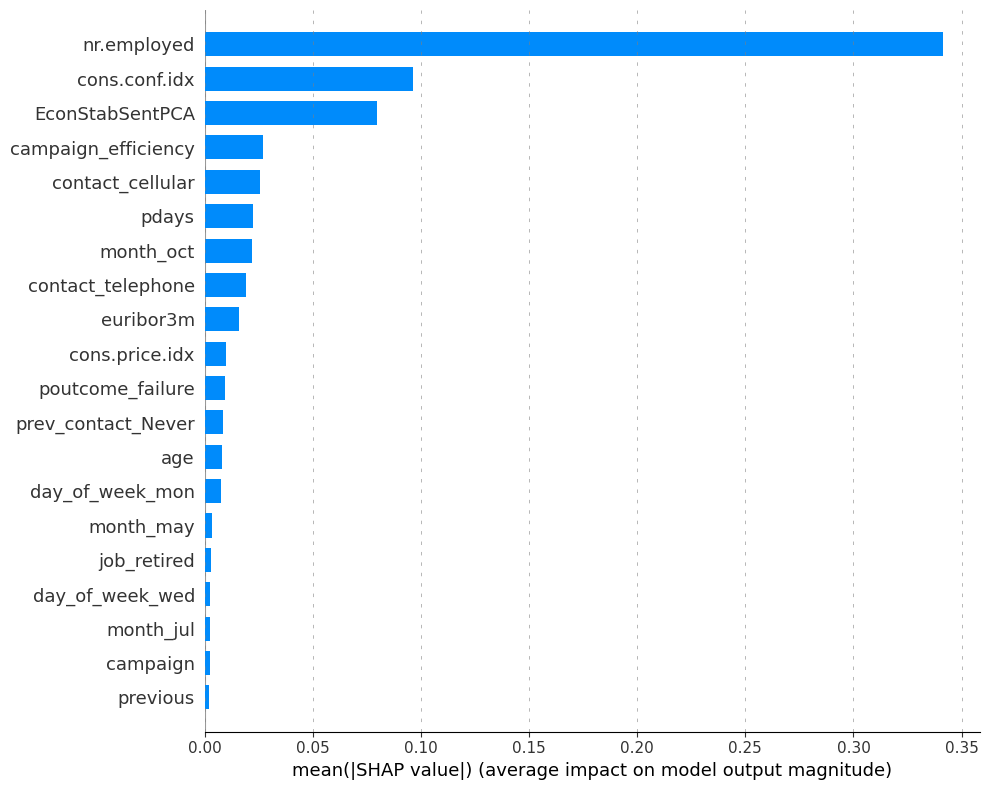

In [27]:
import shap

explainer = shap.TreeExplainer(best_gb_precision)
shap_values = explainer.shap_values(X)
plt.figure()
shap.summary_plot(shap_values, X, plot_type='bar', plot_size=(10,8), show=False)
plt.grid(visible=True, which="major", axis='x', linestyle="--", dashes=(5, 10), color='gray', linewidth=0.5, alpha=0.8)
plt.savefig('modelsA-plots/axboost-gboost-shap-mean.pdf')
plt.show()

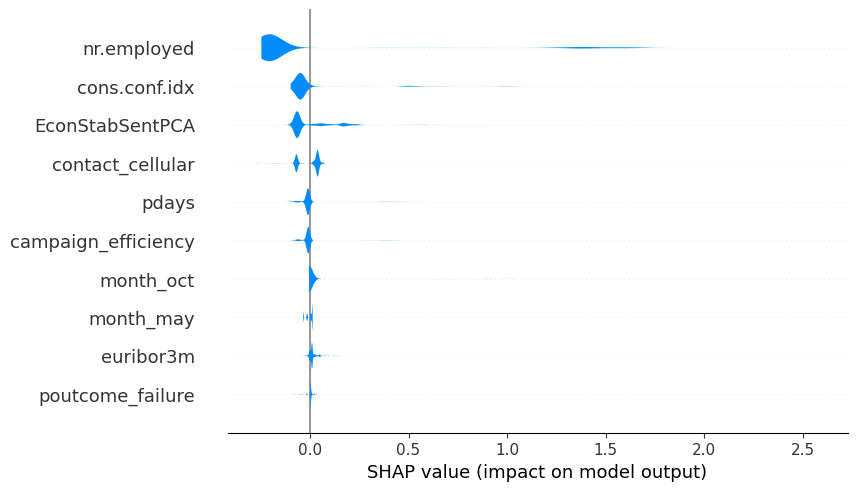

In [49]:
shap.plots.violin(shap_values, feature_names=X.columns, max_display=10)

Quelques plots très très lourds

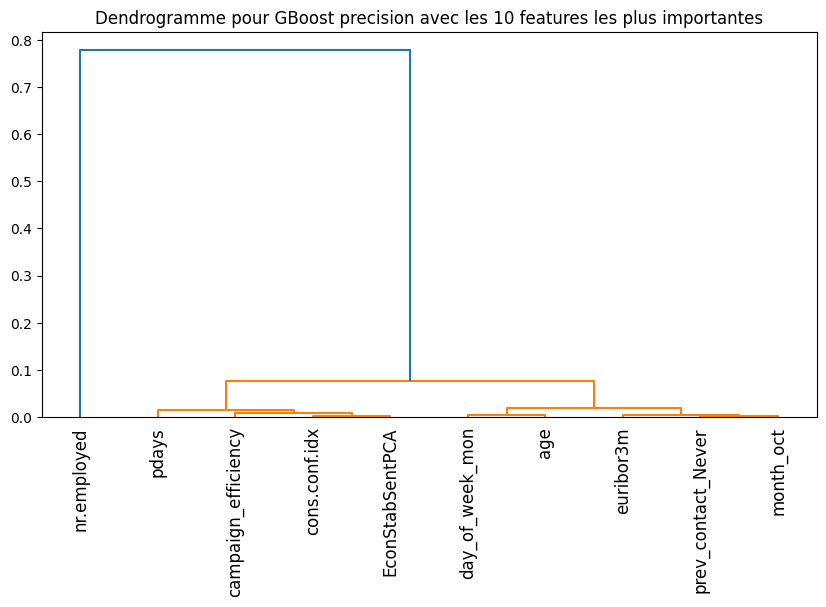

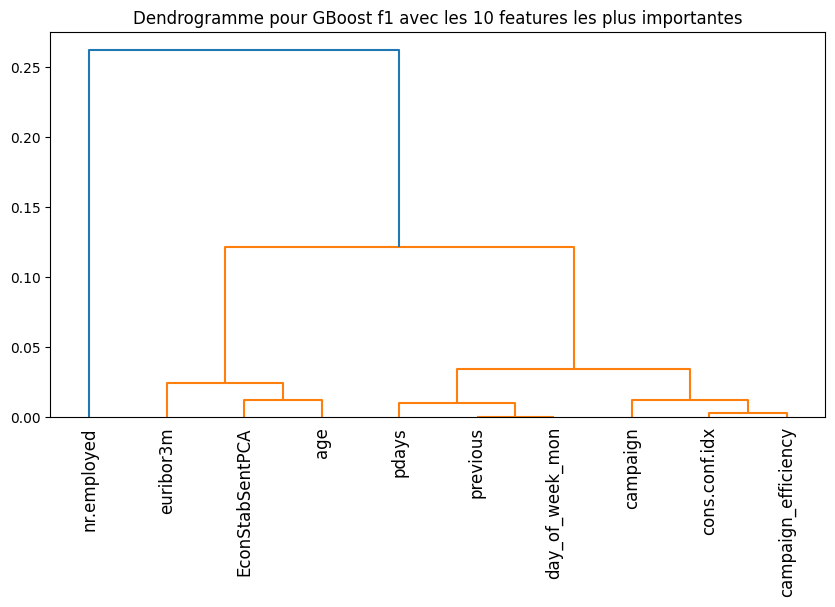

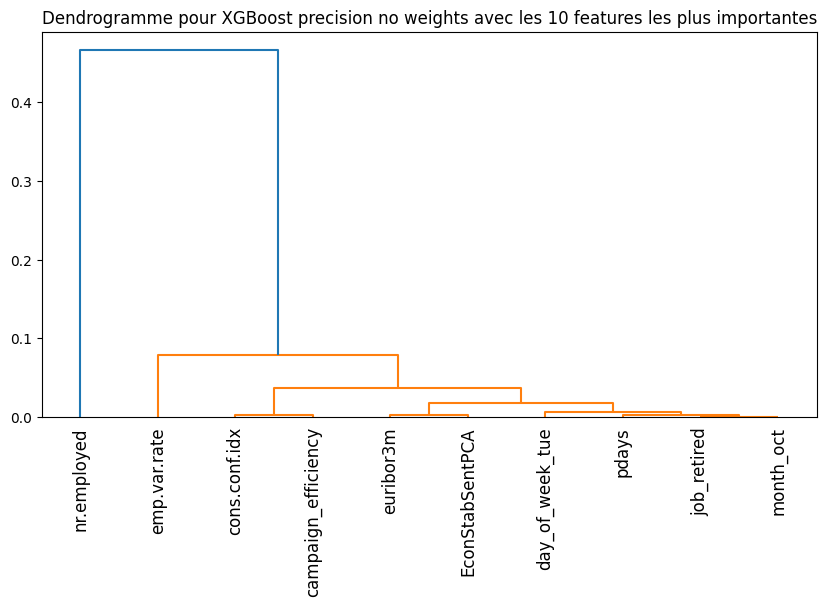

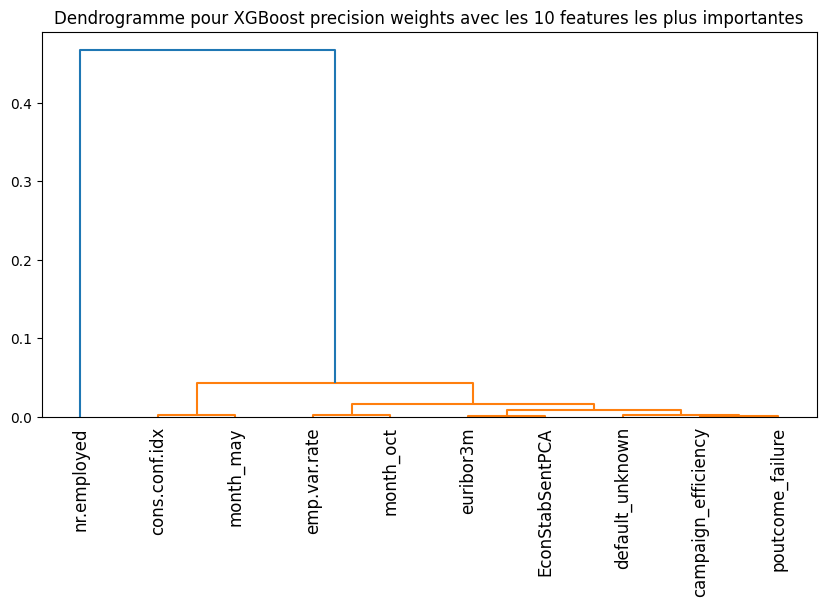

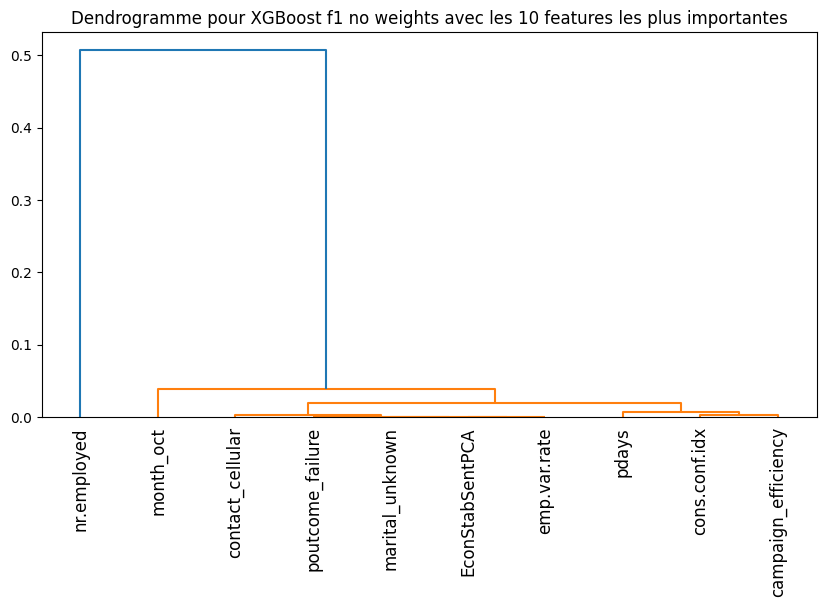

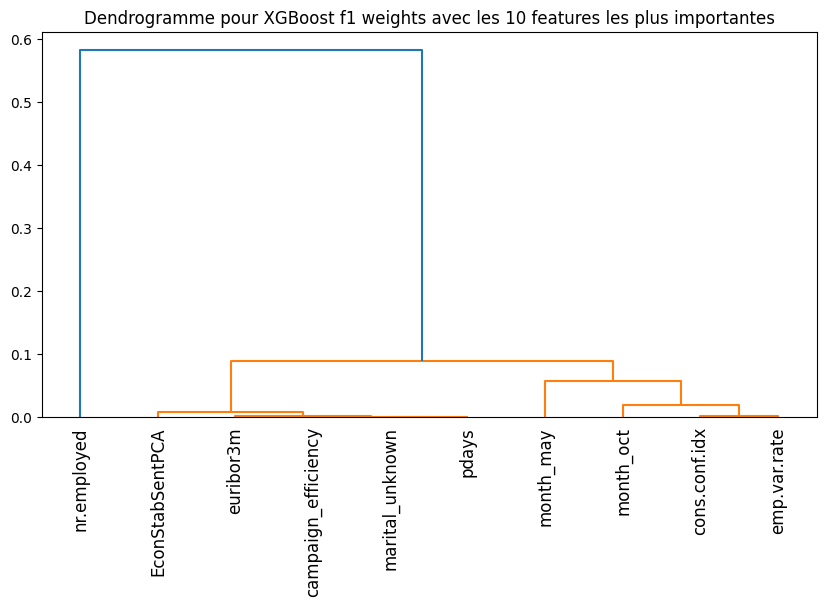

In [28]:
from scipy.cluster import hierarchy

for name, model in classifiers.items():
    feature_importances = model.feature_importances_
    top_indices = np.argsort(feature_importances)[-10:]
    top_importances = feature_importances[top_indices]
    top_features = X_train.columns[top_indices]
    clustering = hierarchy.linkage(top_importances.reshape(-1, 1), method='ward')
    
    plt.figure(figsize=(10, 5))
    plt.title(f"Dendrogramme pour {name} avec les 10 features les plus importantes")
    hierarchy.dendrogram(clustering, labels=top_features, leaf_rotation=90)
    plt.show()


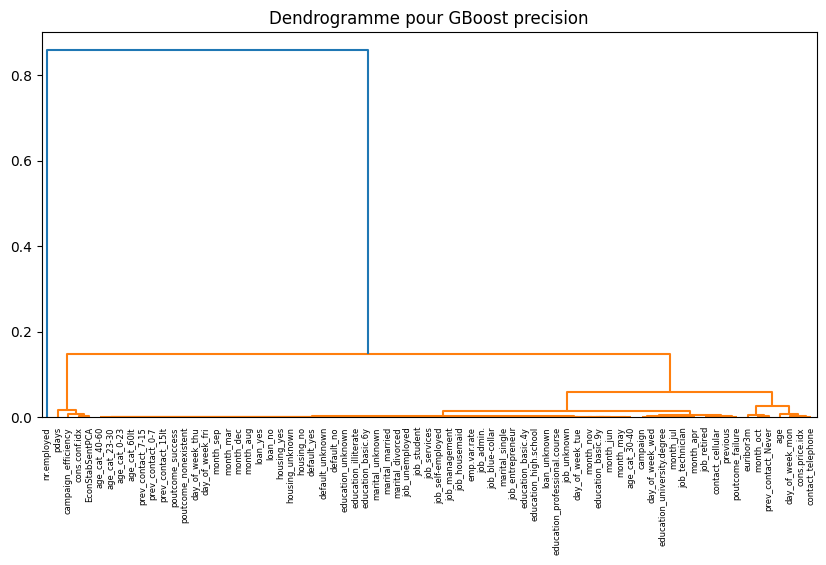

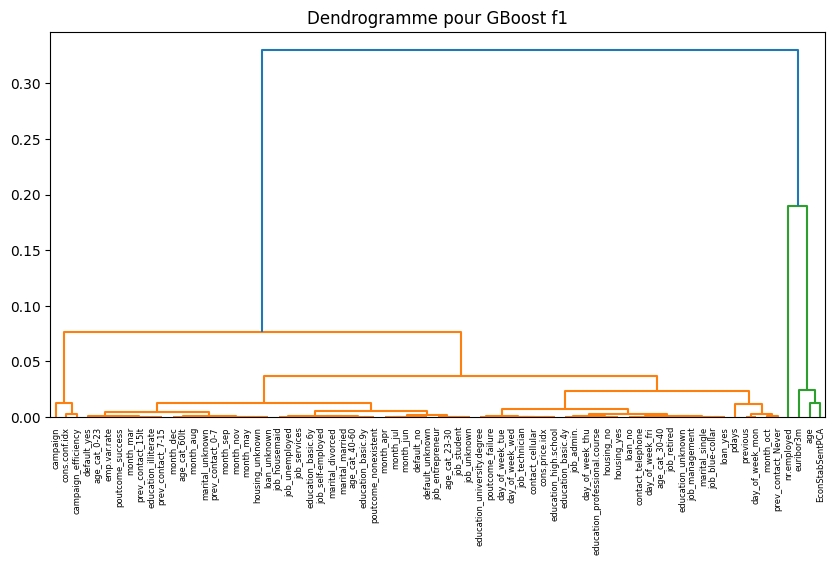

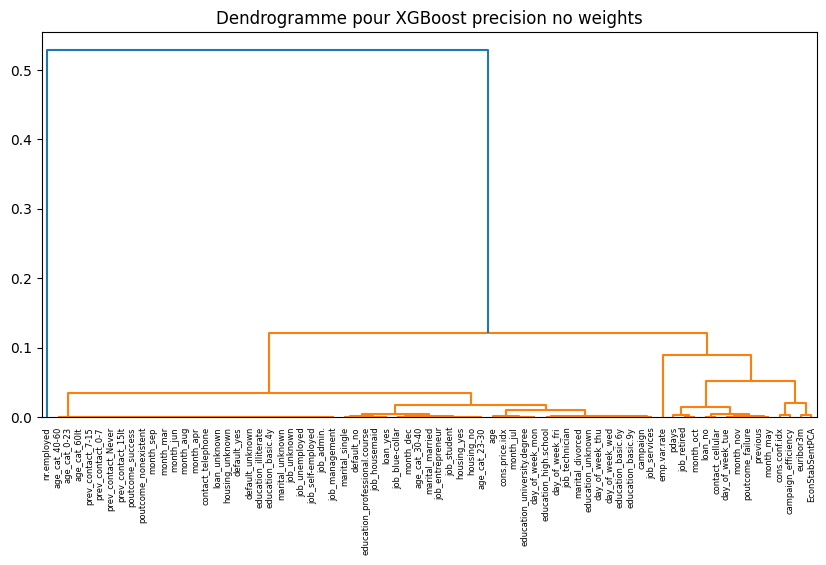

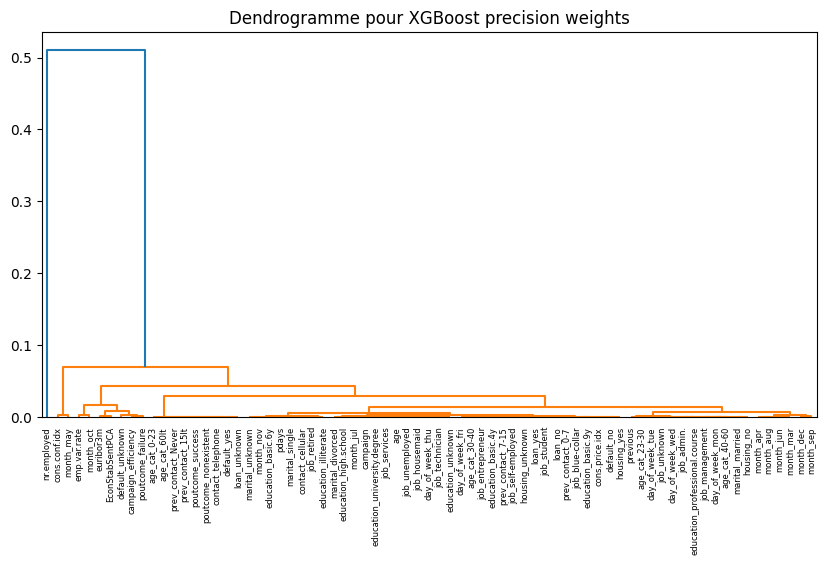

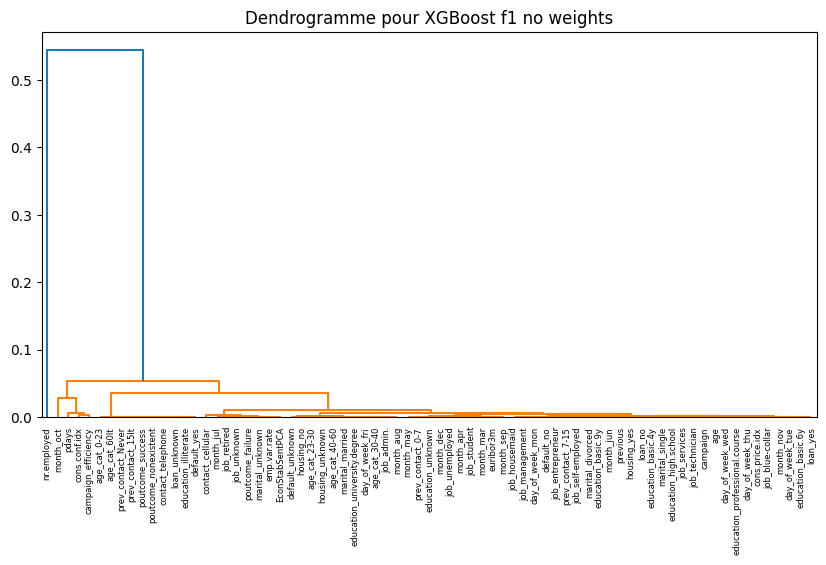

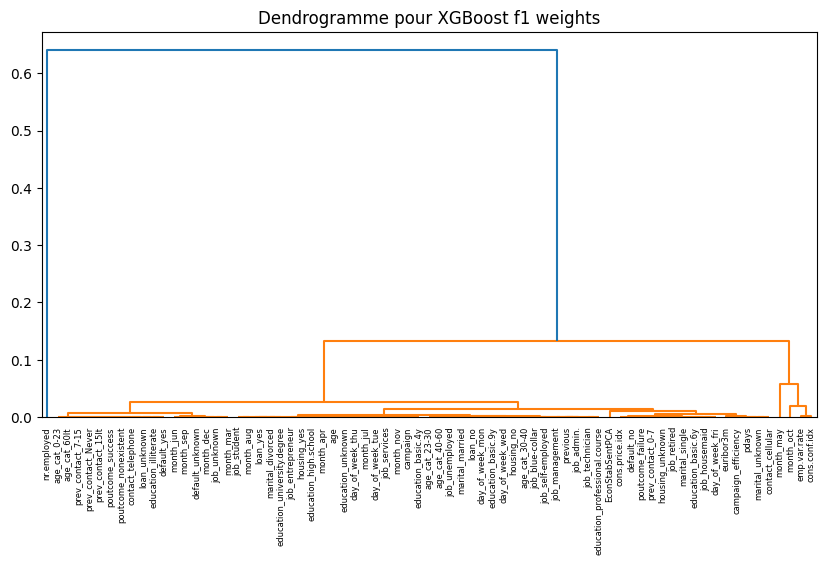

In [29]:
for name, model in classifiers.items():
    
    feature_importances = model.feature_importances_
    clustering = hierarchy.linkage(feature_importances.reshape(-1, 1), method='ward')
        
    plt.figure(figsize=(10, 5))
    plt.title(f"Dendrogramme pour {name}")
    hierarchy.dendrogram(clustering, labels=X_train.columns, leaf_rotation=90)
    plt.show()